In [1]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*algorithm did not converge.*")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

PHASE1_DIR = Path(".")
PROCESSED_DIR = PHASE1_DIR / "processed"

c:\Users\grzegorzzakrzewski\AppData\Local\miniconda3\envs\SMAC\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
evaluations_df = pd.read_parquet(PROCESSED_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,generator,cost,log_cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,4.74,1.558145,0.95,1.0,0.0,0.0,0.2,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,0.02,-3.506558,0.15,0.0,1.0,1.0,0.4,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,3.72,1.316408,0.20,0.0,1.0,2.0,0.9,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,1.52,0.425268,0.60,1.0,1.0,2.0,0.7,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,84.44,4.436160,0.90,1.0,1.0,3.0,0.3,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1286196444435323941,TSP/TRAIN/grid/019.tsp,grid,208.32,5.339123,0.45,0.0,0.0,0.0,0.2,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99996,1435531534300921454,TSP/TRAIN/grid/019.tsp,grid,300.00,5.703816,0.20,1.0,0.0,3.0,0.6,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99997,27607668447685341,TSP/TRAIN/grid/019.tsp,grid,3.21,1.169381,0.95,1.0,1.0,3.0,0.9,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99998,2245205590089179674,TSP/TRAIN/grid/019.tsp,grid,17.23,2.847232,0.65,0.0,0.0,1.0,0.5,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201


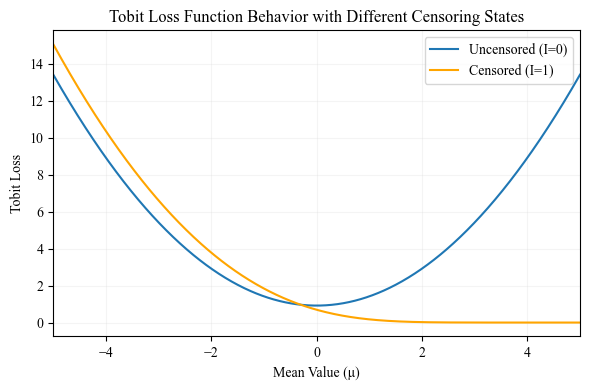

In [3]:
def tobit_loss_numpy(mu, std, c, I):
    z = (c - mu) / std
    uncensored_logpdf = -0.5 * z**2 - 0.5 * np.log(2 * np.pi)
    from scipy import special
    censored_logcdf = special.log_ndtr(-z)  # log(1-Φ(z)) = log(Φ(-z))
    loss = (1 - I) * uncensored_logpdf + I * censored_logcdf
    return -np.mean(loss)

mus = np.linspace(-5, 5, 1000)
std = 1
c = 0
values_i0 = [tobit_loss_numpy(mu, std, c, 0) for mu in mus]
values_i1 = [tobit_loss_numpy(mu, std, c, 1) for mu in mus]

plt.figure(figsize=(6, 4))
plt.plot(mus, values_i0, label='Uncensored (I=0)')
plt.plot(mus, values_i1, color="orange", label='Censored (I=1)')

plt.xlabel('Mean Value (μ)')
plt.ylabel('Tobit Loss')
plt.title('Tobit Loss Function Behavior with Different Censoring States')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import CyclicLR
from torch.utils.data import DataLoader, TensorDataset

from utils import get_n_splits

In [5]:
train_idx, test_idx = next(get_n_splits(df, n=2, instance_number=10, solver_number=300, random_state=0))

df_train = df.loc[train_idx]
X_train = df_train.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
y_train = df_train["log_cost"].clip(upper=np.log(1 + 0.01))
is_censored_train = (df_train["cost"] >= 1 + 0.01).to_numpy()

df_test = df.loc[test_idx]
X_test = df_test.drop(columns=["solver_id", "instance_id", "generator", "cost", "log_cost"])
y_test = df_test["log_cost"]

# X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()
# X_test = X_test.to_numpy()
# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X_scaler = MinMaxScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten()

# to tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
is_censored_train = torch.tensor(is_censored_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

In [11]:
# Model
class TobitNet(nn.Module):
    def __init__(self, input_dim, init_bias_std):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.mu = nn.Linear(50, 1)
        self.log_sigma = nn.Linear(50, 1)
        self.log_sigma.bias.data.fill_(init_bias_std.log())

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        mu = self.mu(x).squeeze(-1)
        sigma = F.softplus(self.log_sigma(x)).squeeze(-1)
        return mu, sigma

# Loss
def tobit_loss(mu, sigma, y, is_censored):
    eps = 1e-6
    z = (y - mu) / (sigma + eps)
    log_pdf = -0.5 * (z**2 + torch.log(2 * torch.pi * (sigma**2 + eps)))
    log_sf = torch.log(1 - 0.5 * (1 + torch.erf(z / 2**0.5)) + eps)
    loss = -((1 - is_censored) * log_pdf + is_censored * log_sf)
    return loss.mean()

dataset = TensorDataset(X_train, y_train, is_censored_train)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

init_std = y_train.std()
model = TobitNet(input_dim=X_train.shape[1], init_bias_std=init_std)
optimizer = SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)
scheduler = CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-2, step_size_up=100, mode='triangular')

# Training
model.train()
for epoch in tqdm(range(200)):
    for X_batch, y_batch, censored_batch in loader:
        mu_pred, sigma_pred = model(X_batch)
        loss = tobit_loss(mu_pred, sigma_pred, y_batch, censored_batch.float())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), 0.1)
        optimizer.step()
        scheduler.step()

100%|██████████| 200/200 [00:14<00:00, 13.66it/s]


In [12]:
y_pred, _ = model(X_test)
y_pred = y_pred.detach().numpy()
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

<Axes: ylabel='Frequency'>

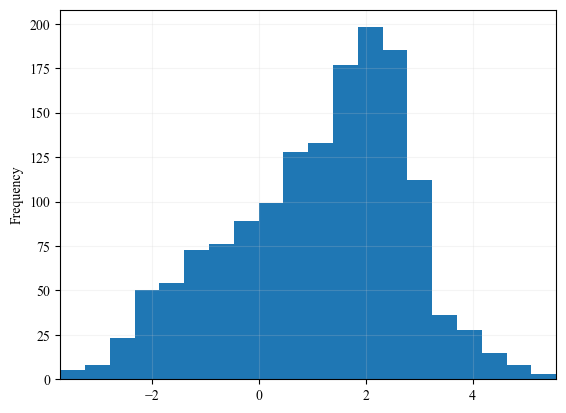

In [13]:
pd.Series(y_pred).plot.hist(bins=20)

<Axes: ylabel='Frequency'>

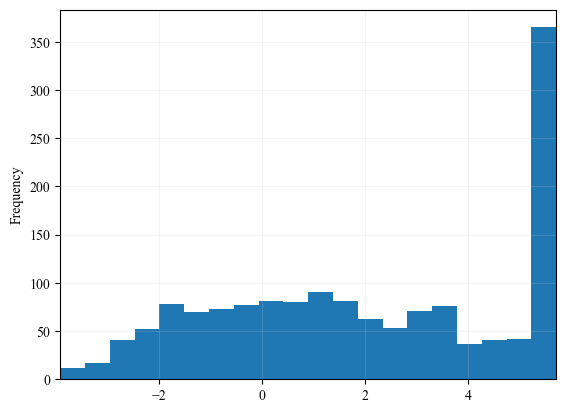

In [6]:
pd.Series(y_test).plot.hist(bins=20)
# pd.Series(y_train_test).plot.hist(bins=20)

In [1]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sc = ax.scatter(
    np.exp(y_test) - 1,
    np.exp(y_pred) - 1,
    alpha=0.5,
    edgecolors="k",
    lw=0.2,
    s=3,
)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(0.01, 320)
ax.set_ylim(0.01, 320)
ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
ax.axhline(y=1, color='red', linestyle='--')

ax.set_ylabel("Predicted Runtime")
ax.set_xlabel("Actual Runtime")
# plt.savefig("xgboost_aft.png", dpi=300, bbox_inches="tight")
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# class TobitNet(nn.Module):
#     def __init__(self, input_dim, init_log_std):
#         super().__init__()
#         self.hidden1 = nn.Linear(input_dim, 50)
#         self.hidden2 = nn.Linear(50, 50)
#         self.hidden3 = nn.Linear(50, 50)
#         self.mu_head = nn.Linear(50, 1)
#         self.log_std_head = nn.Linear(50, 1)
#         self.log_std_head.bias.data.fill_(init_log_std)

#     def forward(self, x):
#         x = torch.tanh(self.hidden1(x))
#         x = torch.tanh(self.hidden2(x))
#         x = torch.tanh(self.hidden3(x))
#         mu = self.mu_head(x).squeeze(-1)
#         std = F.softplus(self.log_std_head(x)).squeeze(-1)
#         std = torch.clamp(std, min=1e-6)
#         return mu, std
    

def tobit_loss(mu, std, c, I):
    std = torch.clamp(std, min=1e-6)
    z = (c - mu) / std
    log_two_pi = torch.log(torch.tensor(2 * torch.pi, device=mu.device))
    uncensored_logpdf = -0.5 * z**2 - 0.5 * log_two_pi
    cdf = 0.5 * (1 + torch.erf(z / torch.sqrt(torch.tensor(2.0, device=mu.device))))
    censored_logcdf = torch.log(torch.clamp(1 - cdf, min=1e-12))
    loss = (1 - I) * uncensored_logpdf + I * censored_logcdf
    return -loss.sum()

# data = TensorDataset(X_train, y_train, is_censored_train)
# dataloader = DataLoader(data, batch_size=16, shuffle=True)

# model = TobitNet(input_dim=X_train.shape[1], init_log_std=y_train.std())
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-2, step_size_up=2000, mode='triangular')

# for epoch in tqdm(range(1000)):
#     for xb, cb, Ib in dataloader:
#         mu, std = model(xb)
#         loss = tobit_loss(mu, std, cb, Ib)
#         optimizer.zero_grad()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1, norm_type=1)
#         optimizer.step()
#         scheduler.step()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np

class TobitNetwork(nn.Module):
    def __init__(self, input_dim, hidden_size=50):
        super(TobitNetwork, self).__init__()
        
        # Network architecture
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        
        # Output layers - one for mean, one for variance
        self.mean_out = nn.Linear(hidden_size, 1)
        self.var_out = nn.Linear(hidden_size, 1)
        
        # Activation functions
        self.activation = nn.Tanh()
        self.softplus = nn.Softplus()
        
        # Initialize variance output bias to match data std (1.0 after normalization)
        self.var_out.bias.data.fill_(np.log(np.exp(1.0) - 1))  # Inverse softplus of 1.0
        
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        
        mean = self.mean_out(x)
        var = self.softplus(self.var_out(x))  # Ensure positive variance
        
        return mean, var

class TobitLoss(nn.Module):
    def __init__(self):
        super(TobitLoss, self).__init__()
        
    def forward(self, mean_pred, var_pred, y_true, is_censored):
        """
        Compute Tobit loss:
        -log L = -sum[ log(phi(Z_i)^{1-I_i} * (1 - Phi(Z_i))^{I_i} ]
        where I_i is the censoring indicator (1 if censored, 0 otherwise)
        and Z_i = (y_true_i - mean_pred_i) / sqrt(var_pred_i)
        """
        std = torch.sqrt(var_pred)
        z = (y_true - mean_pred) / std
        
        # Standard normal pdf and cdf
        normal = torch.distributions.Normal(0, 1)
        log_phi = normal.log_prob(z)  # log of standard normal pdf
        log_Phi = torch.log(1 - normal.cdf(z))  # log of survival function (1 - cdf)
        
        # Tobit log likelihood
        log_likelihood = (1 - is_censored) * log_phi + is_censored * log_Phi
        
        # Return negative log likelihood
        return -log_likelihood.mean()

def train_model(X_train, y_train, is_censored_train, input_dim, epochs=100):
    # Create dataset and dataloader
    dataset = TensorDataset(X_train, y_train, is_censored_train)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    
    # Initialize model
    model = TobitNetwork(input_dim)
    criterion = TobitLoss()
    
    # Optimizer with weight decay (L2 regularization)
    optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
    
    # One-cycle learning rate scheduler
    scheduler = OneCycleLR(optimizer, max_lr=1e-2, steps_per_epoch=len(dataloader), epochs=epochs)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for batch_X, batch_y, batch_censored in dataloader:
            optimizer.zero_grad()
            
            # Forward pass
            mean_pred, var_pred = model(batch_X)
            
            # Compute loss
            loss = criterion(mean_pred.squeeze(), var_pred.squeeze(), batch_y, batch_censored)
            
            # Backward pass and optimize
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=0.1)
            
            optimizer.step()
            scheduler.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(dataloader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')
    
    return model

# Example usage:
# Assuming X_train, y_train, is_censored_train are already torch tensors
input_dim = X_train.shape[1]
model = train_model(X_train, y_train, is_censored_train, input_dim, epochs=200)

Epoch 1/200, Loss: 1.4250
Epoch 2/200, Loss: 1.1280
Epoch 3/200, Loss: 0.9624
Epoch 4/200, Loss: 0.8703
Epoch 5/200, Loss: 0.8204
Epoch 6/200, Loss: 0.7859
Epoch 7/200, Loss: 0.7615
Epoch 8/200, Loss: 0.7425
Epoch 9/200, Loss: 0.7252
Epoch 10/200, Loss: 0.7118
Epoch 11/200, Loss: 0.6989
Epoch 12/200, Loss: 0.6827
Epoch 13/200, Loss: 0.6666
Epoch 14/200, Loss: 0.6477
Epoch 15/200, Loss: 0.6272
Epoch 16/200, Loss: 0.6069
Epoch 17/200, Loss: 0.5868
Epoch 18/200, Loss: 0.5650
Epoch 19/200, Loss: 0.5473
Epoch 20/200, Loss: 0.5420
Epoch 21/200, Loss: 0.5343
Epoch 22/200, Loss: 0.5283
Epoch 23/200, Loss: 0.5248
Epoch 24/200, Loss: 0.5256
Epoch 25/200, Loss: 0.5179
Epoch 26/200, Loss: 0.5152
Epoch 27/200, Loss: 0.5165
Epoch 28/200, Loss: 0.5135
Epoch 29/200, Loss: 0.5073
Epoch 30/200, Loss: 0.5092
Epoch 31/200, Loss: 0.5057
Epoch 32/200, Loss: 0.5057
Epoch 33/200, Loss: 0.5036
Epoch 34/200, Loss: 0.4992
Epoch 35/200, Loss: 0.5000
Epoch 36/200, Loss: 0.4984
Epoch 37/200, Loss: 0.4953
Epoch 38/2

In [11]:
y_pred, _ = model(X_test)
y_pred = y_pred.detach().numpy()
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_pred

array([13.949273 , 14.680867 , 14.272622 , ...,  2.9258666, 13.000756 ,
       13.571972 ], dtype=float32)

<Axes: ylabel='Frequency'>

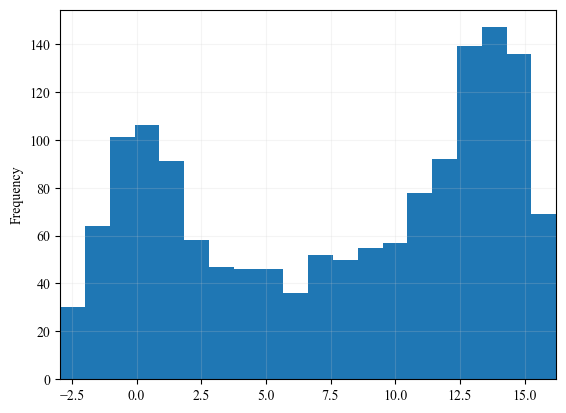

In [12]:
pd.Series(y_pred).plot.hist(bins=20)

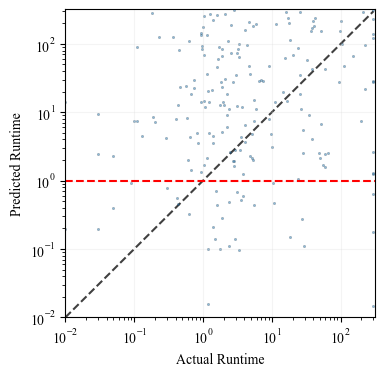

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sc = ax.scatter(
    np.exp(y_test) - 1,
    np.exp(y_pred) - 1,
    alpha=0.5,
    edgecolors="k",
    lw=0.2,
    s=3,
)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(0.01, 320)
ax.set_ylim(0.01, 320)
ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
ax.axhline(y=1, color='red', linestyle='--')

ax.set_ylabel("Predicted Runtime")
ax.set_xlabel("Actual Runtime")
# plt.savefig("xgboost_aft.png", dpi=300, bbox_inches="tight")
plt.show()

tensor([[13.6455],
        [ 7.6564],
        [19.5978],
        ...,
        [34.3310],
        [ 9.0276],
        [19.1762]], grad_fn=<SoftplusBackward0>)